In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from agent import Agent, Env
from pfilter import ParticleFilter
from scipy.special import logsumexp

In [2]:
np.random.seed(10)
random.seed(10)

In [3]:
im_x = 30
im_y = 30

seqlen = 200

n_agents = 1

In [4]:
env = Env(*[Agent(im_x, im_y) for _ in range(n_agents)])

In [5]:
# env.agents[0].dim = env.agents[1].dim
# env.agents[0].pos = env.agents[1].pos
# env.agents[0].vel = env.agents[1].vel

In [6]:
aa = env.step()

In [7]:
aa

[array([ 14.61702713,  15.4745518 ,  22.37981087,  19.75076316])]

In [8]:
def all_permutations(l):
    if l == 0:
        return [[0]]
    else:
        prev = all_permutations(l-1)
        ans = []
        for i in range(l+1):
            for perm in prev:
                tmp = perm[:]
                tmp.insert(i, l)
                ans.append(tmp)
        return ans

In [9]:
def evol_model(particles):
    particles = particles.copy()
    
    xy, wh = particles[:,:2], particles[:,2:4]
    vel = particles[:,4:]
    
    vel += np.random.normal(size=vel.shape)/12
    vel = np.clip(vel, -3, 3)
    
    xy += vel
    
    f = np.logical_or( xy[:,0] < 0, xy[:,0] > im_x)
    vel[f,0] *= -1

    f = np.logical_or( xy[:,1] < 0, xy[:,1] > im_y)
    vel[f,1] *= -1
    
    wh += np.random.normal(size=wh.shape)/40
    wh = np.clip(wh, 1, 30)
    
    xy = np.clip(xy, 0, np.array([im_x, im_y], dtype='float64') - wh)
    
    new_particles = np.concatenate([xy, wh, vel], axis=-1)
    return new_particles

def observe_model(particles, observe, beta=None):
    xy, wh = particles[:,:2], particles[:,2:4]
    
    xyxy = np.concatenate([xy, xy + wh], axis=-1)
    
    whs = np.stack([wh,wh], axis=-1).reshape((-1,4))
    #whs = np.array([10.]*4)
    
    ds = []
    for obs in observe:
        logd = - (xyxy - obs)**2/(2*(whs/12)**2) - np.log(np.sqrt(2*np.pi)*whs/12)
        logd = np.clip(logd, -10000, 10000)
        logd = np.sum(logd, axis=-1)
        ds.append(logd)
    
    
    ds = np.array(ds)

    if beta is not None:
        beta = np.array(beta)
        tmp = logsumexp(ds, b=beta[:,np.newaxis], axis=0)
        #print(beta)
        #print(tmp)
        if np.max(beta) < 1e-3:
            return 0
        else:
            return tmp
    else:
        return ds

In [10]:
filters = []
aa_ = env.step(see_all=True)
for i in range(n_agents):
    filt = ParticleFilter(5000, 4 + 2, evol_model, observe_model, resample_criterion=0.1)
    aa = aa_[i]
    filt.particles[:,4:] = np.random.normal(size=filt.particles[:, 4:].shape)*5
    filt.particles[:, :2] = aa[:2] + np.random.normal(size=filt.particles[:, :2].shape)*0.5
    filt.particles[:, 2:4] = np.clip(aa[2:4] - aa[:2] + np.random.normal(size=filt.particles[:, 2:4].shape)*0.5, 1, 100)
    filters.append(filt)

In [11]:
observe = []
true = []
for _ in range(seqlen):
    observe.append(env.step())
    true.append([agent.pos for agent in env.agents])
    
observe = np.array(observe)
true = np.array(true)

In [12]:
agent = env.agents[0]

In [13]:
agent.w, agent.h

(8, 4)

In [14]:
# ao = list(observe)
# ao = iter(ao)

In [15]:
filtrated = [[]]
fed = [[]]

for obs in observe:
#obs = next(ao)
    betamat = np.zeros([len(filters), len(obs)], dtype='float64')

    for j, oo in enumerate(obs):
        for i, filt in enumerate(filters):
            ds = observe_model(filt.particles, [oo])[0] + filt.logweights
            #print('logweights {} {}: {}'.format(i, j, ds))
            betamat[i, j] = np.mean(np.exp(ds))
    #betamat[np.isnan(betamat)] = 0
    #print(betamat)
    if np.any(np.isnan(betamat)):
        print('broken!')
        break

    betaij = np.zeros_like(betamat)
    for perm in all_permutations(len(filters) - 1):
        for k, j in enumerate(perm[:len(obs)]):
            betaij[j, k] += np.prod(np.diag(betamat[perm,:][:len(obs)]))

    betaij /= np.sum(betaij)
    #print(betaij)
    #betaij[np.isnan(betaij)] = 0

    for i, filt in enumerate(filters):
        part, w = filt.step(obs, betaij[i,:])
        fed[-1].append((part, w))
        ix = np.random.choice(np.arange(len(part)), size=len(part), p=w)
        filtrated[-1].append(part[ix])
        #print('after update {}'.format(filt.logweights))
    filtrated.append([])
    fed.append([])

0.147816369105
0.0015638245041
0.179436012061
0.0116637664484
0.245910694164
0.221458561931
0.118347062295
0.112480428929
0.000428608697787
0.400050106937
0.0404775160535
0.32308001472
0.0199276425612
0.0651415437326
0.0237566091492
0.0367726381195
0.0134645417009
0.0110370413232
0.153624506445
0.00628719015829
0.203330931713
0.0579415215581
0.882465849829
0.685292068152
0.627350654449
0.000534431739873
0.510137460614
0.253540970058
0.065828961764
0.164546545075
0.0124940110503
0.0310568746037
0.0165614832892
0.00995640961209
0.00261072737464
0.00237273722343
0.000255573527991
nan
broken!


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less


In [16]:
betamat

array([[ nan]])

In [17]:
filtrated = np.array(filtrated[:-1])

In [18]:
filtrated.shape

(43, 1, 5000, 6)

In [19]:
filtrated = filtrated.transpose([0,2,1,3])

In [20]:
fmean = filtrated.mean(axis=1)

In [21]:
fmean.shape

(43, 1, 6)

In [22]:
filtrated.shape

(43, 5000, 1, 6)

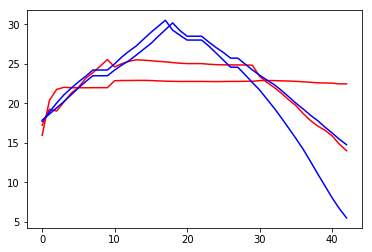




Object Dims:


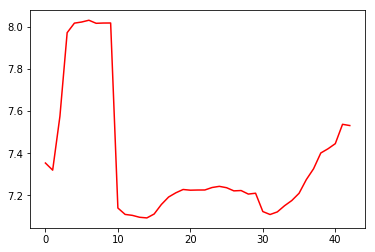

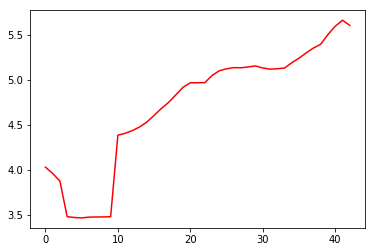

In [23]:
lfm = fmean.shape[0]
for i in range(n_agents):
    plt.plot(range(fmean.shape[0]), fmean[:,i,:2], c='r')
    plt.plot(range(fmean.shape[0]), true[:lfm,i], c='b')
    plt.show()

print('\n\n\nObject Dims:')
plt.plot(range(fmean.shape[0]), fmean[:,:,2], c='r')
plt.show()

plt.plot(range(fmean.shape[0]), fmean[:,:,3], c='r')
plt.show()

In [24]:
# for k in fed[:1]:
#     moment, weights = k[0]
#     hist, xa , ya = np.histogram2d(moment[:,0], moment[:,1], bins=50, weights=weights)
    
#     fig, ax1 = plt.subplots(1,1)
#     ax1.imshow(hist, cmap='jet', interpolation='nearest')
#     ax1.set_xticklabels(xa)
#     ax1.set_yticklabels(ya)
    
#     moment, weights = k[1]
#     hist, xa , ya = np.histogram2d(moment[:,0], moment[:,1], bins=50, weights=weights)
    
#     fig, ax1 = plt.subplots(1,1)
#     ax1.imshow(hist, cmap='jet', interpolation='nearest')
#     ax1.set_xticklabels(xa)
#     ax1.set_yticklabels(ya)
#     plt.show()

In [25]:
images = []
key = np.random.randint(0, 255, 3)

for i, obs in enumerate(true):
    im = np.zeros([im_x, im_y, 3])
    pred = filtrated[i]
    
    for particle in range(filtrated.shape[1]):
        for filt in range(fmean.shape[1]):
            f = pred[particle, filt][:2].astype('int')
            im[tuple(f)] = (key*(filt+1))%255#filt + 2
    for h, obj in enumerate(obs):
        im[tuple(obj.astype('int'))] = (255,0,0)
    images.append(im)
    if i > 100:
        break

KeyboardInterrupt: 

In [26]:
import cv2

In [40]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 20.0, (im_x,im_y))

for im in images:
    frame = im #cv2.resize(im, (,48))
    ret = True
    if ret==True:
        frame = cv2.flip(frame,0)

        # write the flipped frame
        out.write(frame)

        cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release everything if job is finished
out.release()
cv2.destroyAllWindows()

In [36]:
frame.shape

(48, 64, 3)

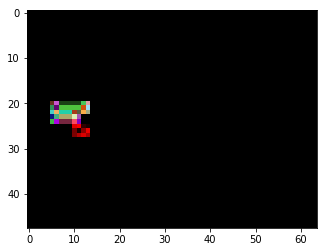

In [37]:
plt.imshow(frame)
plt.show()

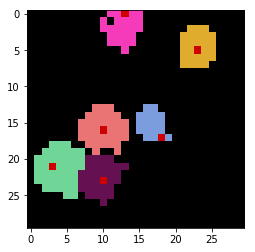

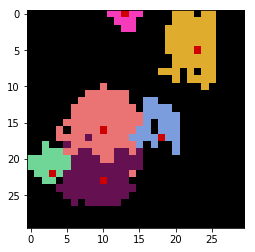

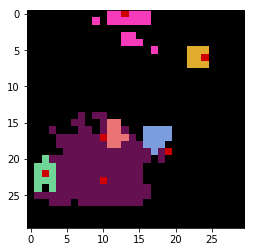

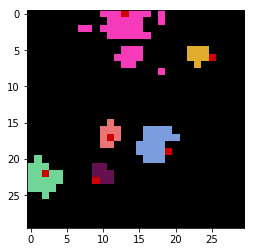

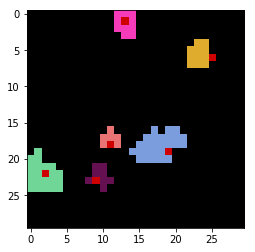

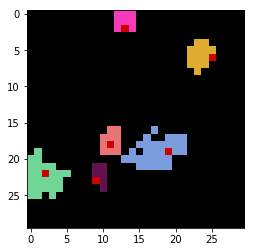

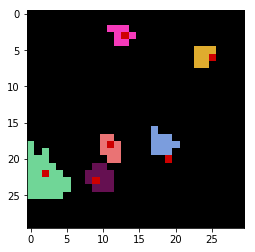

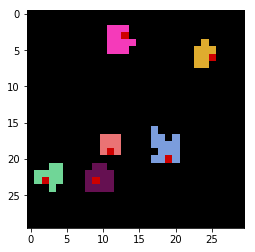

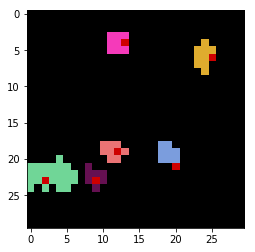

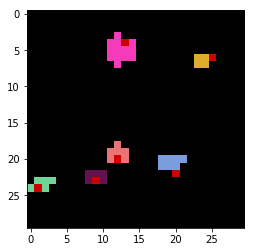

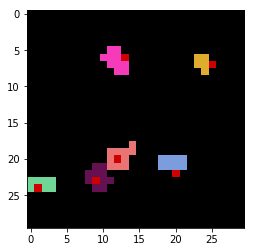

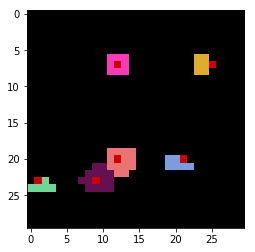

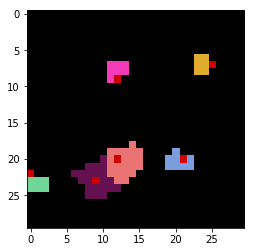

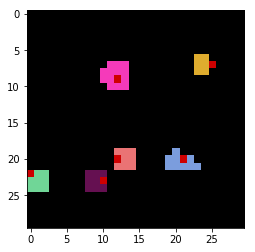

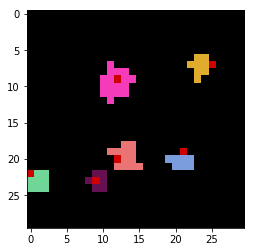

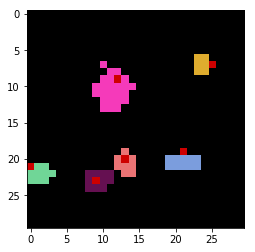

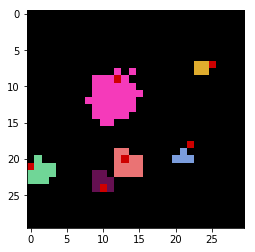

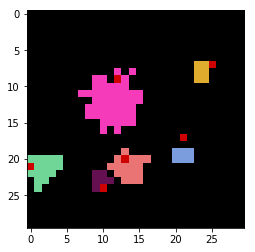

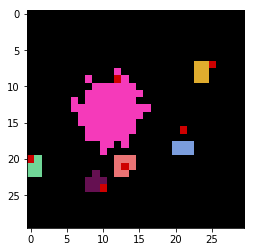

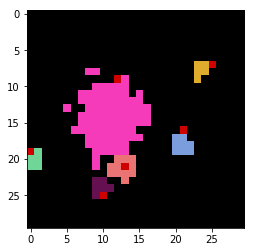

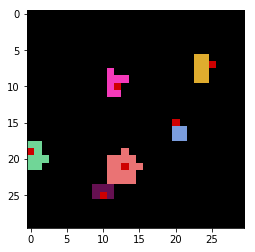

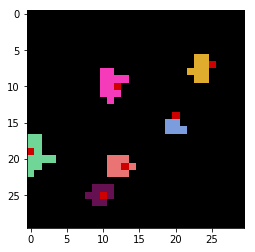

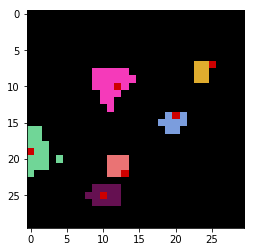

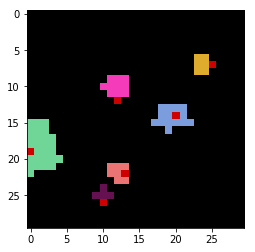

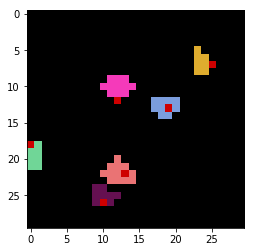

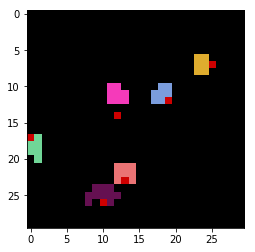

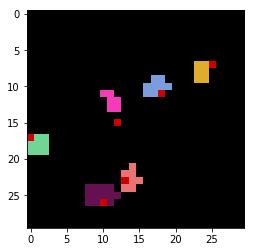

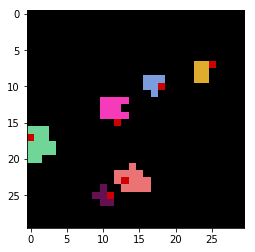

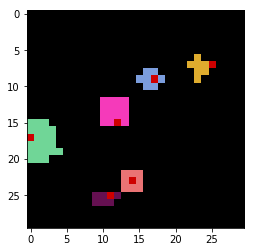

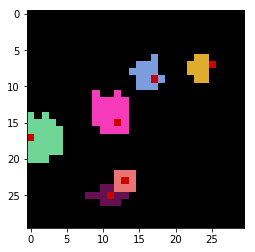

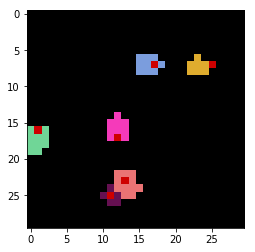

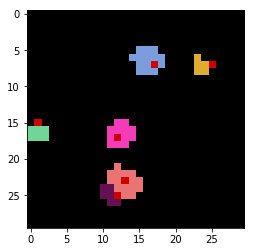

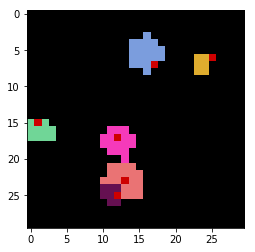

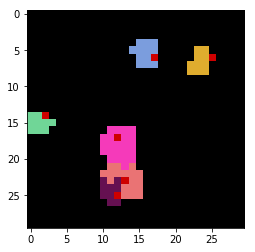

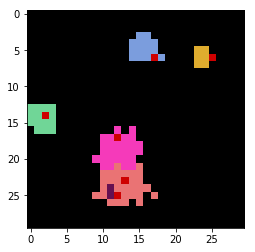

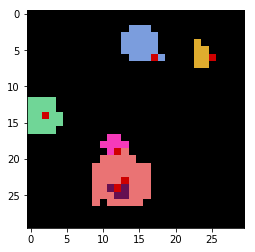

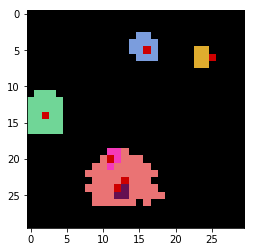

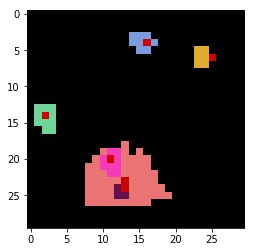

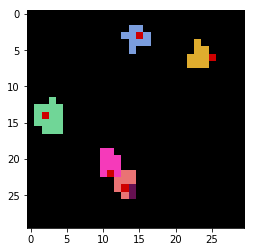

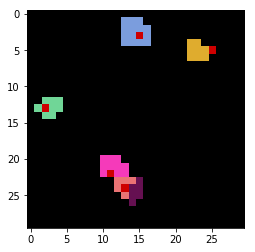

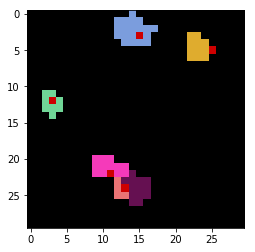

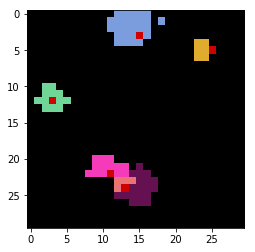

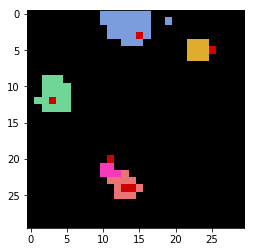

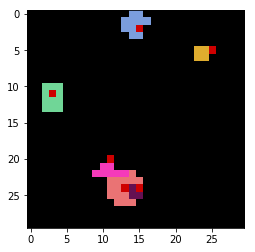

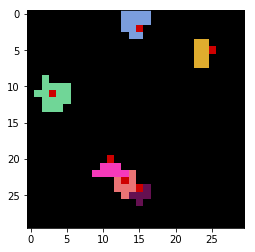

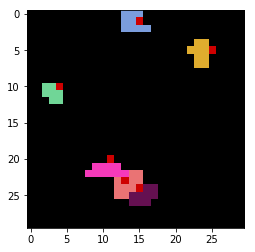

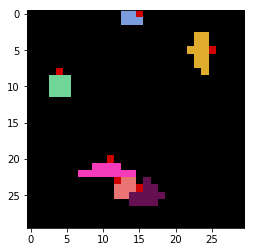

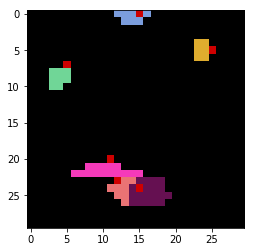

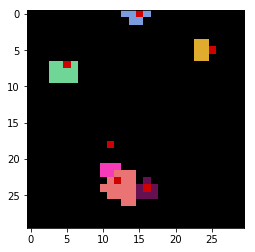

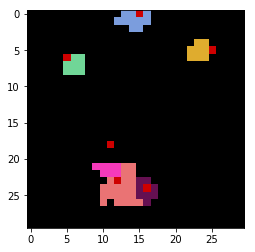

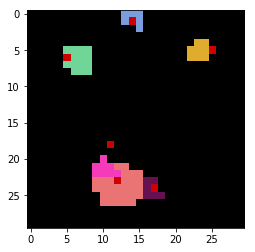

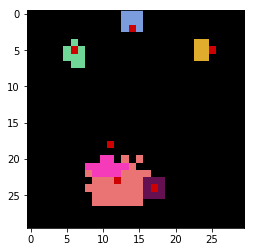

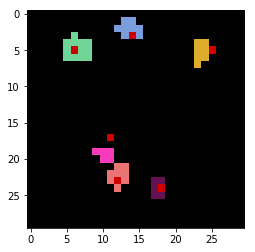

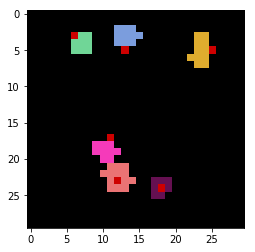

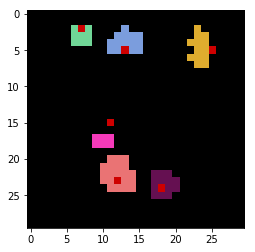

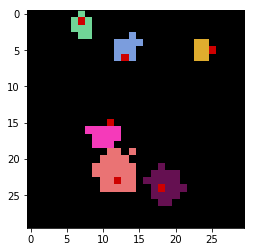

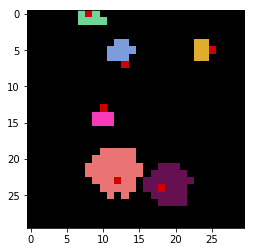

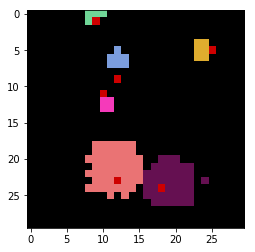

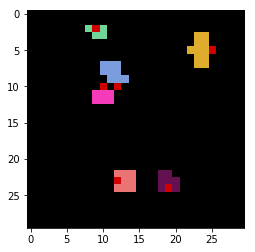

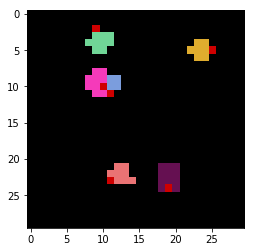

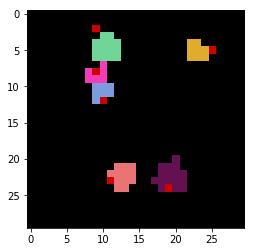

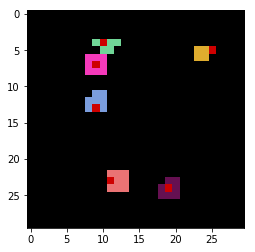

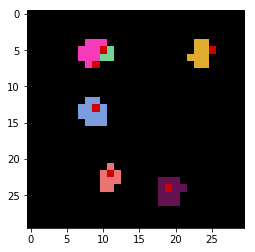

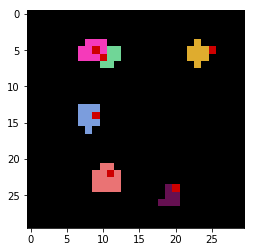

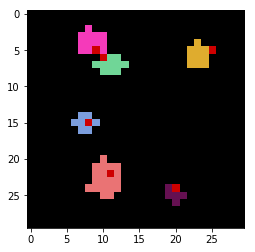

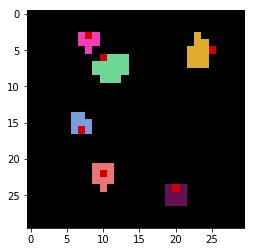

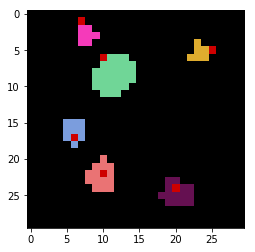

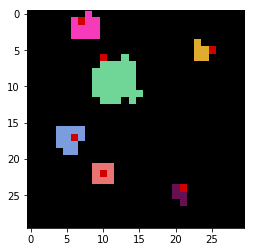

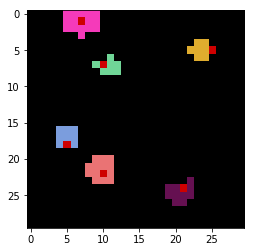

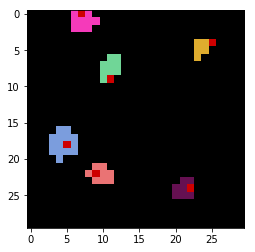

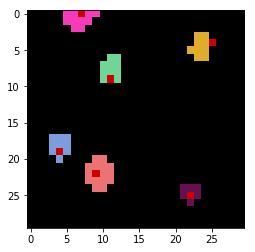

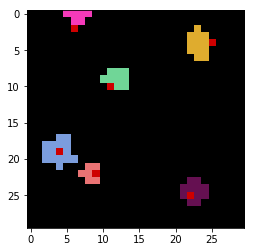

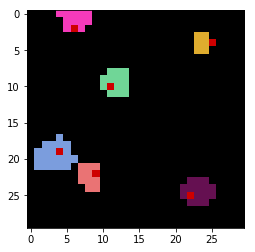

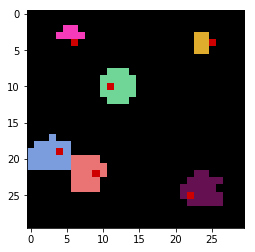

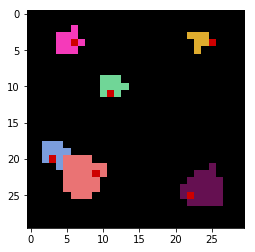

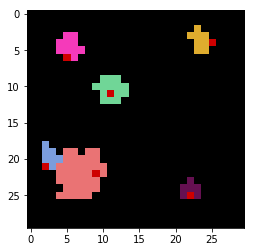

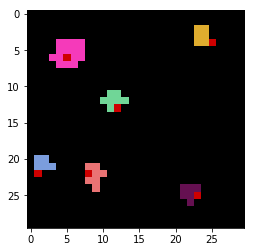

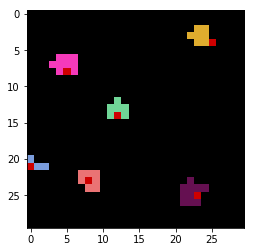

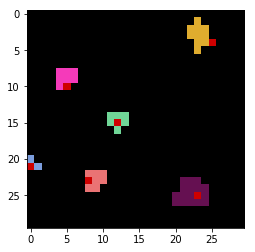

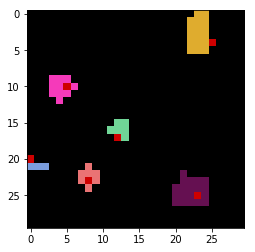

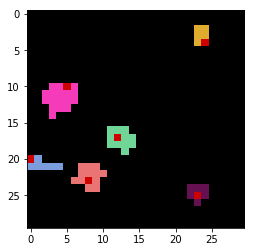

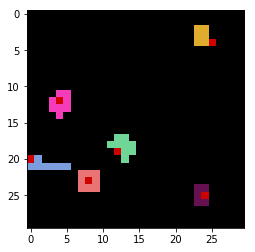

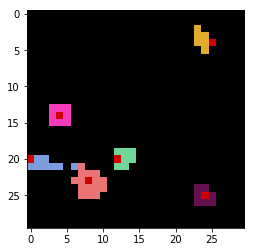

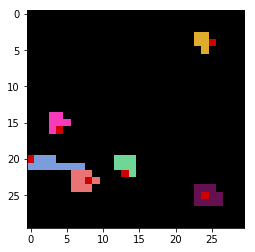

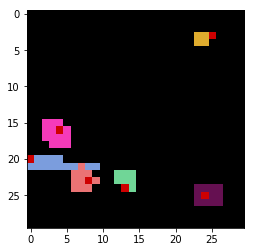

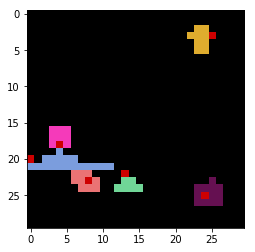

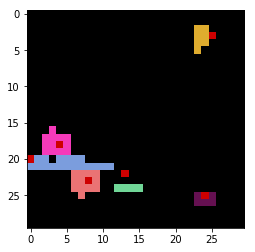

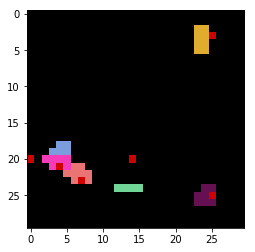

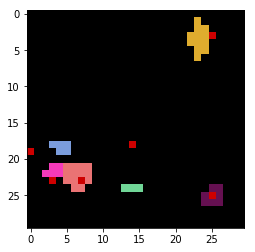

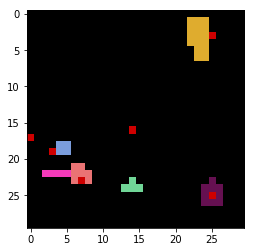

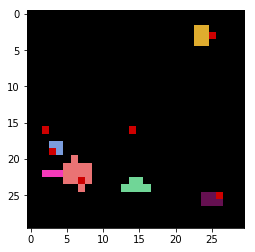

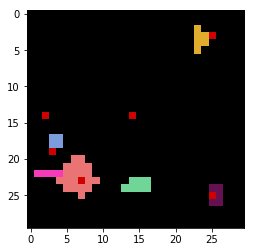

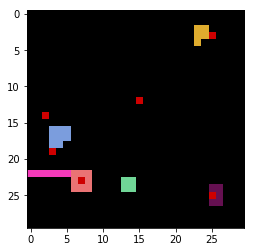

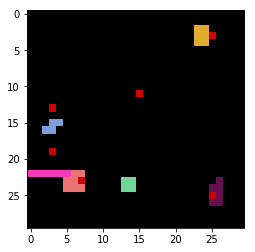

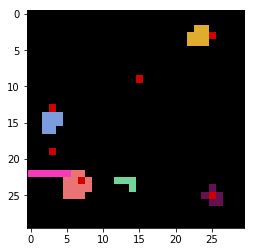

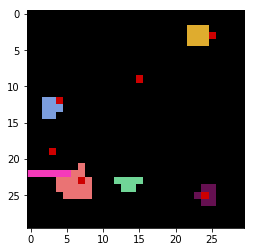

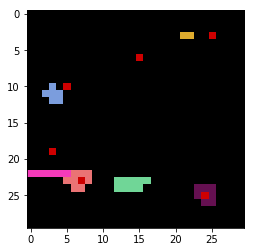

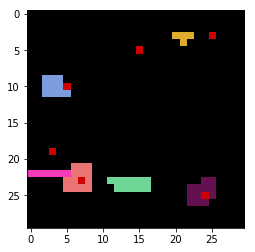

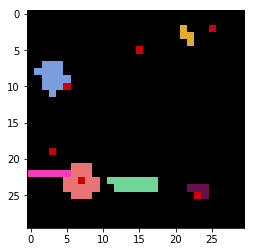

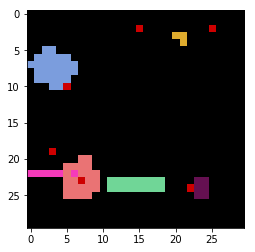

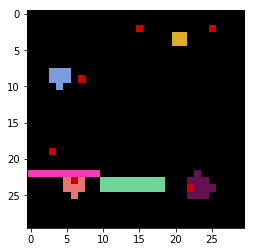

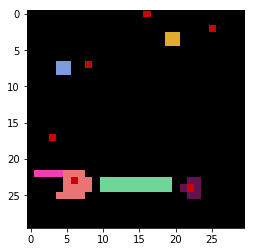

In [26]:
for im in images:
    plt.imshow(im)
    plt.show()